## Data

In [1]:
import numpy as np
import pandas as pd
from datasets.radcure import load_radcure
from sklearn.model_selection import train_test_split

from utils.utils import setup_env


setup_env()

path = "/u/97/nguyenq10/unix/HUS/cancer-clusters/datasets/radcure/clinical_train.csv"
x, y, cfg0 = load_radcure(path)

2024-02-15 17:30:45.230749: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-15 17:30:45.313150: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


CWD: /m/home/home9/97/nguyenq10/unix/HUS/cancer-clusters
GPU: /physical_device:GPU:0
x.shape=(1800, 45), y.shape=(1800, 2)


2024-02-15 17:30:49.661233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-15 17:30:49.679898: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-15 17:30:49.679974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Latent Dimension

{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 2, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


2024-02-15 17:30:49.714418: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-15 17:30:49.714983: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-15 17:30:49.715093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-15 17:30:49.715135: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), bu

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-02-15 17:30:52.547416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-15 17:30:52.549688: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fcb7cfcb4d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-15 17:30:52.549701: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-02-15 17:30:52.552385: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-15 17:30:52.613903: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Progress: 100%|██████████| 1000/1000 [00:38<00:00, 25.93it/s, loss=20.5953, val_output_5_cindex_metric=0.

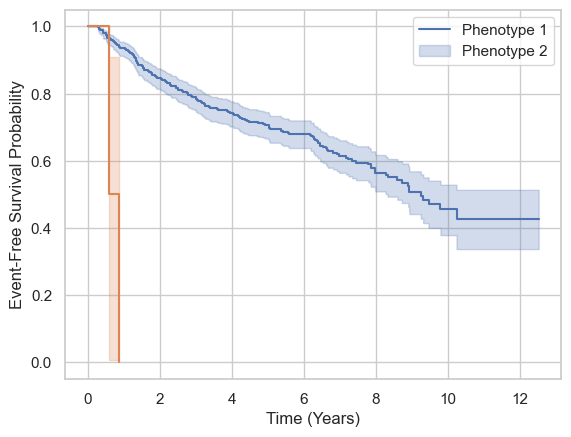

[0.15219250602174011]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 3, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:37<00:00, 26.69it/s, loss=21.9931, val_output_5_cindex_metric=0.7206]


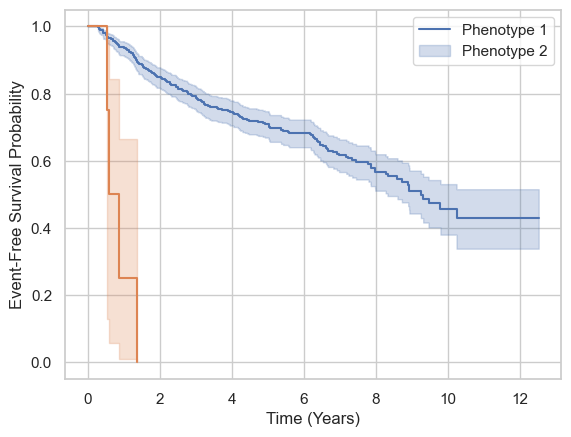

[0.15036171808830018]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 4, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:37<00:00, 26.55it/s, loss=20.9218, val_output_5_cindex_metric=0.7210]


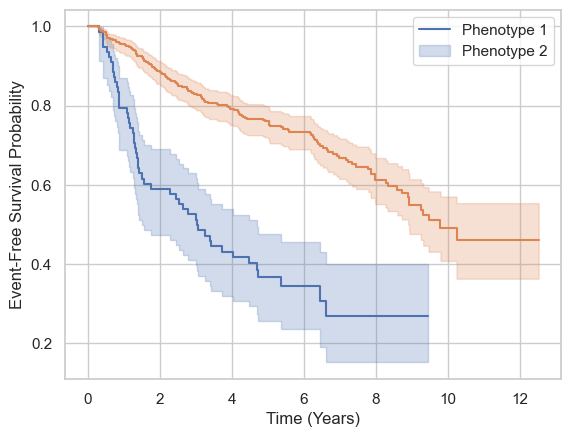

[0.14126060349281153]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 5, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:37<00:00, 26.67it/s, loss=21.5360, val_output_5_cindex_metric=0.6624]


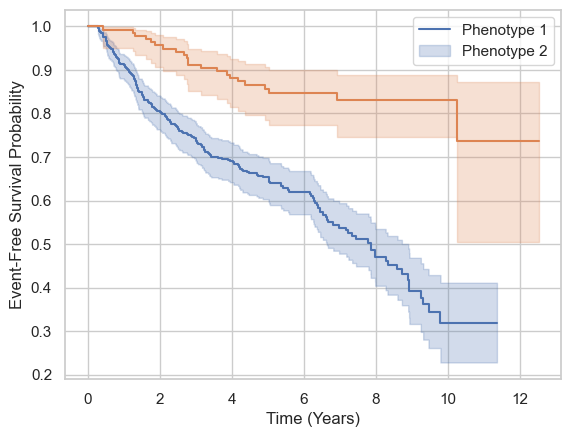

[0.14841794167579928]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 6, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:37<00:00, 26.67it/s, loss=23.4824, val_output_5_cindex_metric=0.7222]


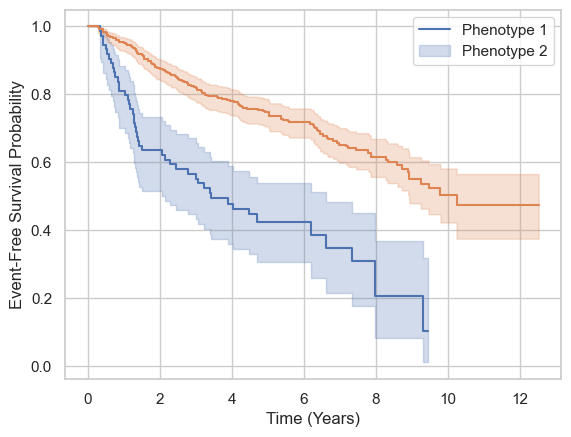

[0.14529053485133336]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 7, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:37<00:00, 26.58it/s, loss=23.1558, val_output_5_cindex_metric=0.7190]


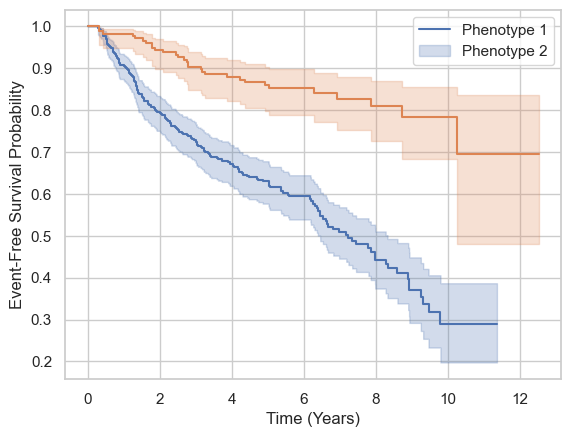

[0.1467066804377672]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 8, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:37<00:00, 26.68it/s, loss=24.5788, val_output_5_cindex_metric=0.6524]


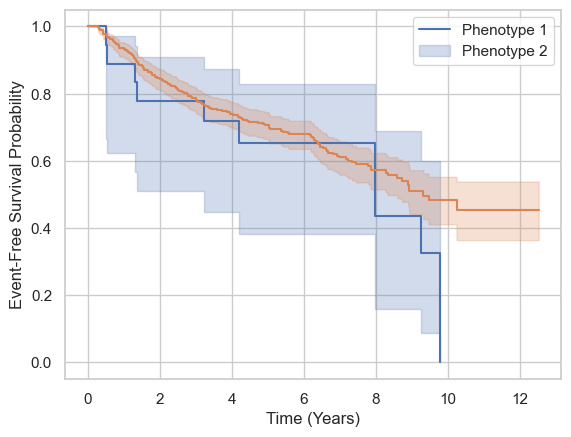

[0.15414400228151123]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 9, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:37<00:00, 26.71it/s, loss=25.6438, val_output_5_cindex_metric=0.6240]


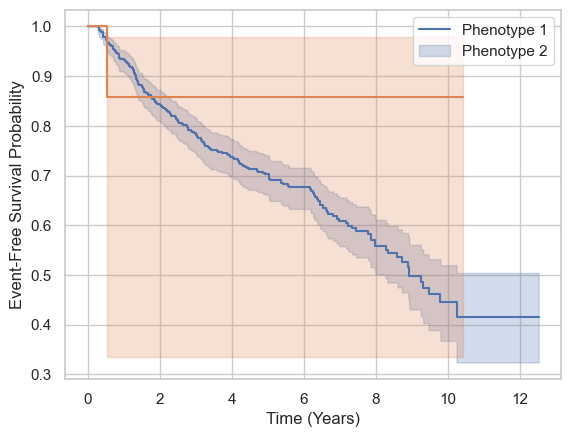

[0.15405048174289063]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 10, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:37<00:00, 26.58it/s, loss=26.0897, val_output_5_cindex_metric=0.7249]


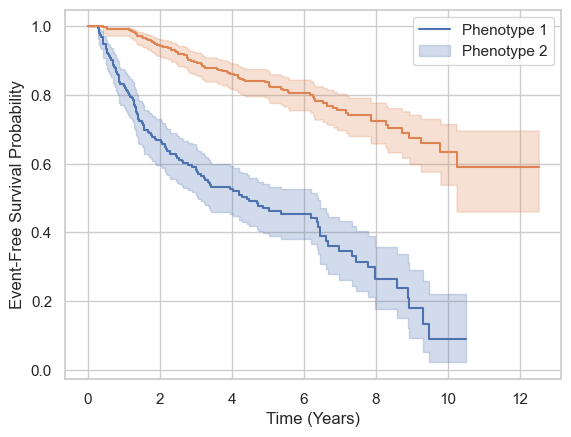

[0.1324345009453864]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 11, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:37<00:00, 26.46it/s, loss=27.3251, val_output_5_cindex_metric=0.5397]


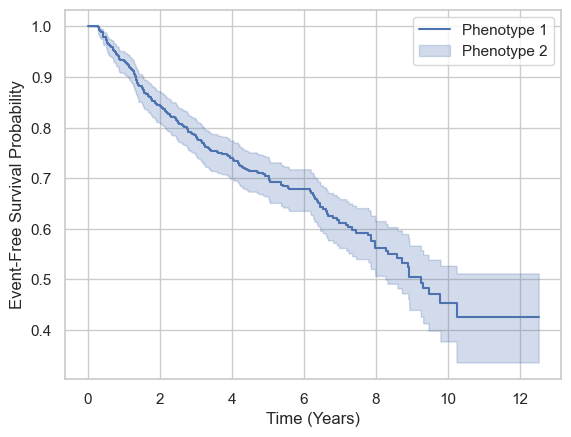

[0.15421600441309719]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 12, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:37<00:00, 26.52it/s, loss=28.4593, val_output_5_cindex_metric=0.6018]


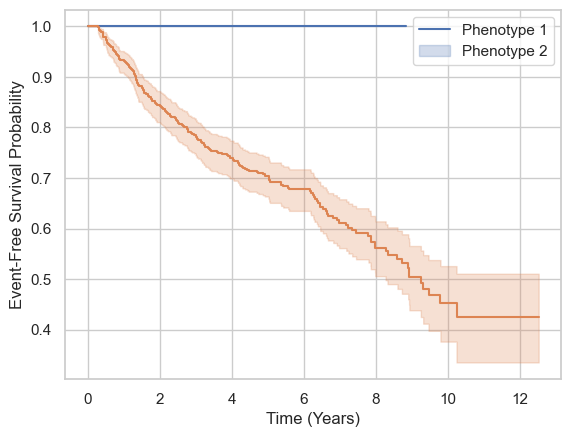

[0.1540978599475166]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 13, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:37<00:00, 26.53it/s, loss=29.4149, val_output_5_cindex_metric=0.6856]


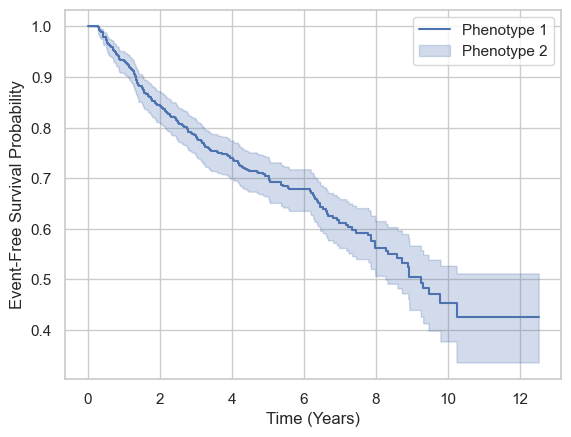

[0.15421600441309719]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 14, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:37<00:00, 26.56it/s, loss=30.2219, val_output_5_cindex_metric=0.7246]


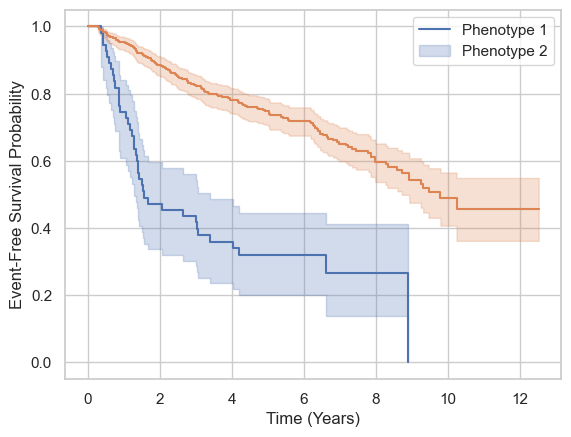

[0.14026499542644494]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 15, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:37<00:00, 26.40it/s, loss=30.3445, val_output_5_cindex_metric=0.7351]


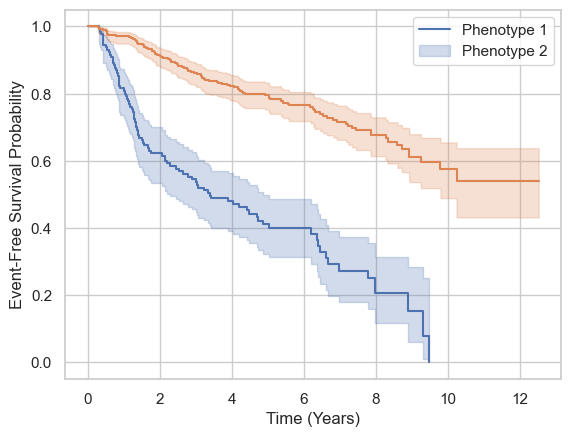

[0.13612408125144693]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 16, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:37<00:00, 26.63it/s, loss=31.6221, val_output_5_cindex_metric=0.7220]


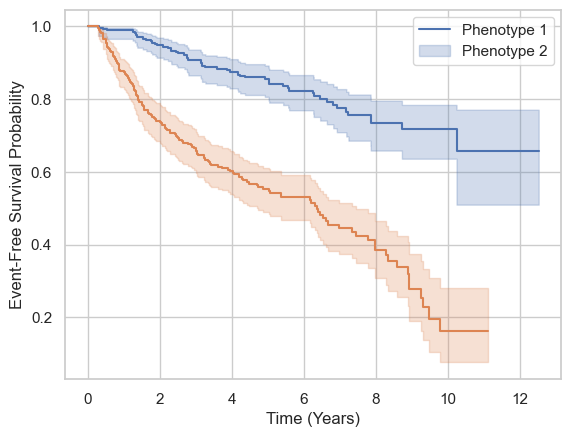

[0.13905690942179397]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 17, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:37<00:00, 26.63it/s, loss=32.9407, val_output_5_cindex_metric=0.5911]


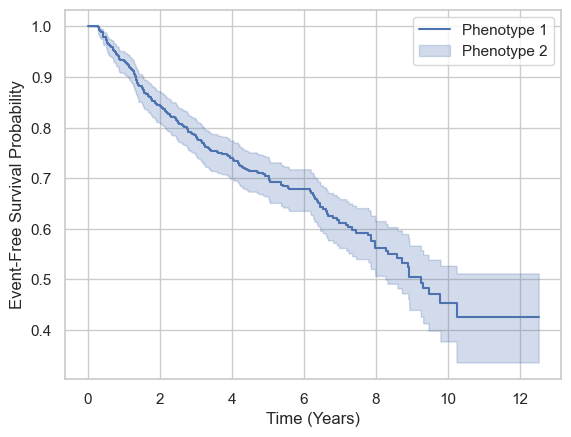

[0.15421600441309719]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 18, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:37<00:00, 26.42it/s, loss=33.6514, val_output_5_cindex_metric=0.6263]


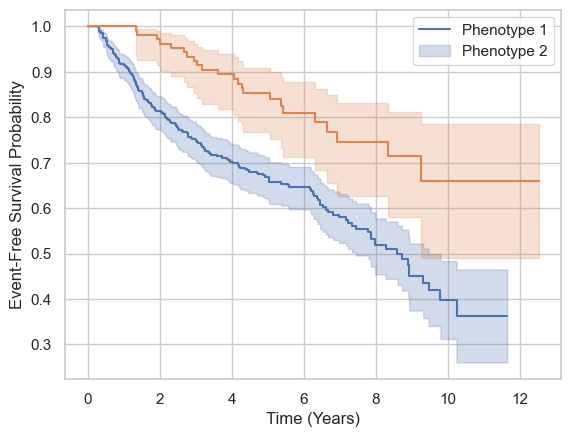

[0.1503551673520038]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 19, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:38<00:00, 26.13it/s, loss=34.8295, val_output_5_cindex_metric=0.5255]


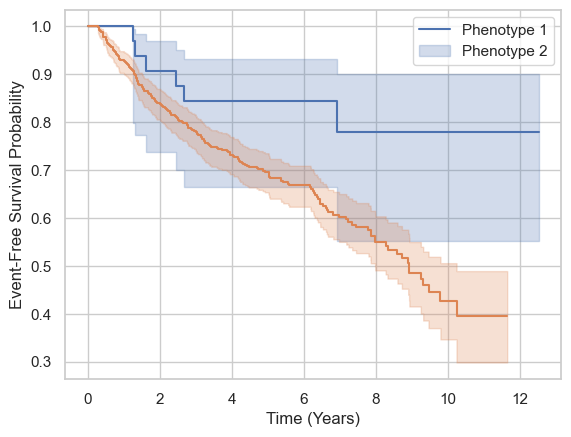

[0.1535658091910701]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 20, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:38<00:00, 26.26it/s, loss=35.3851, val_output_5_cindex_metric=0.6447]


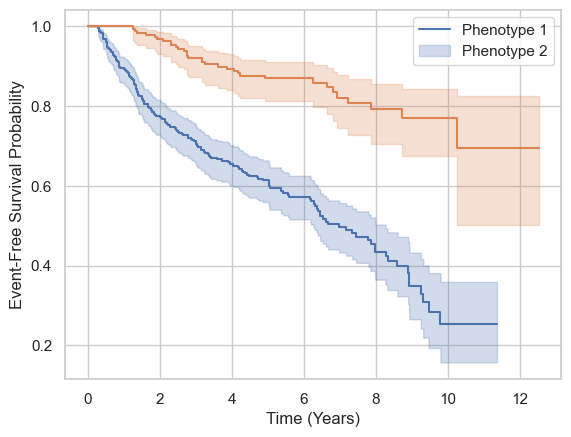

[0.143367510526003]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 21, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:37<00:00, 26.50it/s, loss=36.3591, val_output_5_cindex_metric=0.7019]


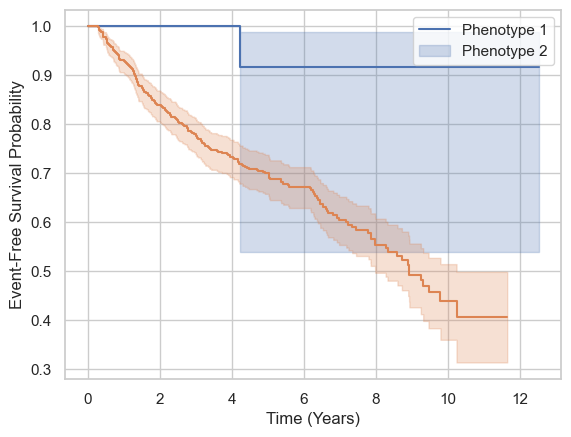

[0.1533969166224641]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 22, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:38<00:00, 26.24it/s, loss=36.9615, val_output_5_cindex_metric=0.7149]


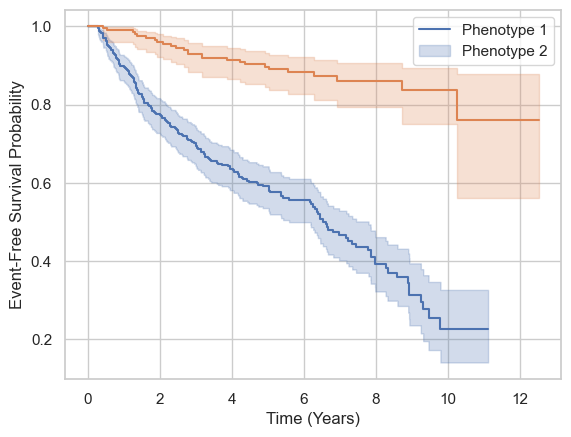

[0.14038040786497524]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 23, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:38<00:00, 26.31it/s, loss=37.7361, val_output_5_cindex_metric=0.7007]


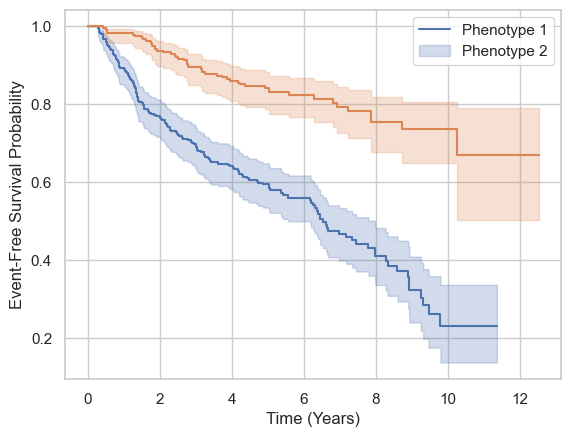

[0.14416846071791659]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 24, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:38<00:00, 26.30it/s, loss=38.7884, val_output_5_cindex_metric=0.6963]


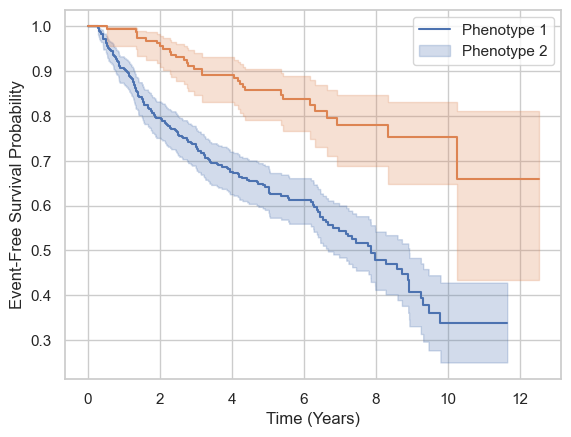

[0.1476988081057042]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 25, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:38<00:00, 26.06it/s, loss=40.1032, val_output_5_cindex_metric=0.7169]


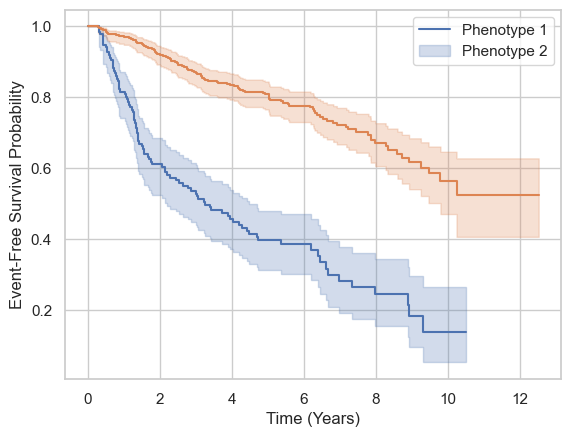

[0.1336620240575455]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 26, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:38<00:00, 26.09it/s, loss=41.1018, val_output_5_cindex_metric=0.6072]


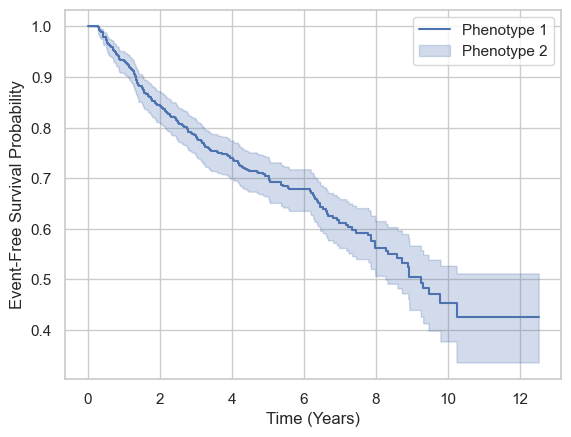

[0.15421600441309719]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 27, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:38<00:00, 26.19it/s, loss=41.6859, val_output_5_cindex_metric=0.5802]


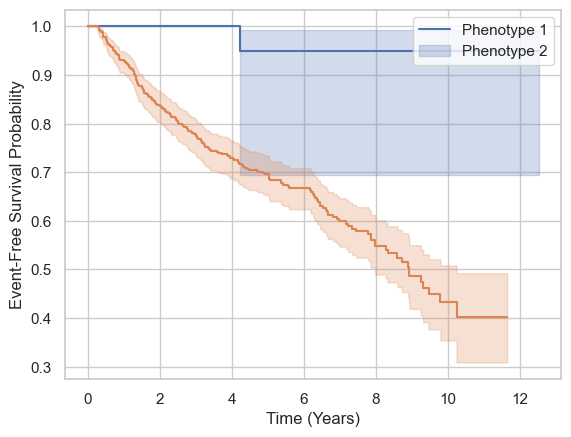

[0.15257862103281492]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 28, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:37<00:00, 26.44it/s, loss=42.6266, val_output_5_cindex_metric=0.6822]


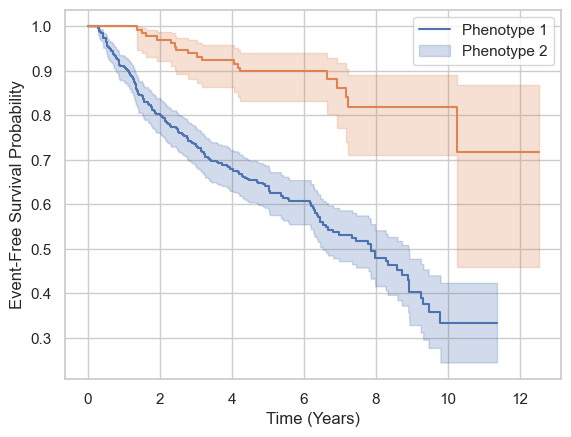

[0.14638014115372608]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 29, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:38<00:00, 26.23it/s, loss=43.3353, val_output_5_cindex_metric=0.4865]


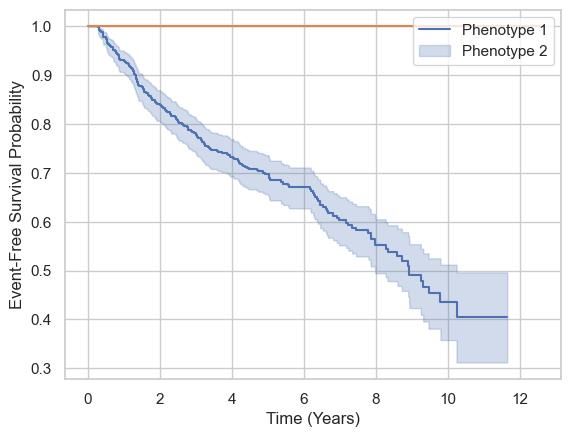

[0.15301092224291968]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 30, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:38<00:00, 26.09it/s, loss=44.1575, val_output_5_cindex_metric=0.7409]


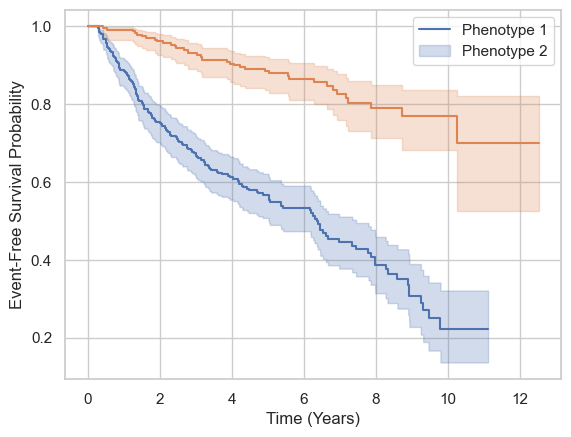

[0.13787196663813656]
{'seed': 0, 'inp_shape': 45, 'num_clusters': 2, 'latent_dim': 31, 'monte_carlo': 1, 'learn_prior': False, 'weibull_shape': 2.5, 'sample_surv': False, 'activation': 'relu', 'survival': True, 'epochs': 1000, 'layers': [100], 'learning_rate': 0.001, 'train_size': 0.7, 'workdir': './runs/radcure/Feb15_17-30-49_glass'}


Progress: 100%|██████████| 1000/1000 [00:37<00:00, 26.36it/s, loss=45.3876, val_output_5_cindex_metric=0.6612]


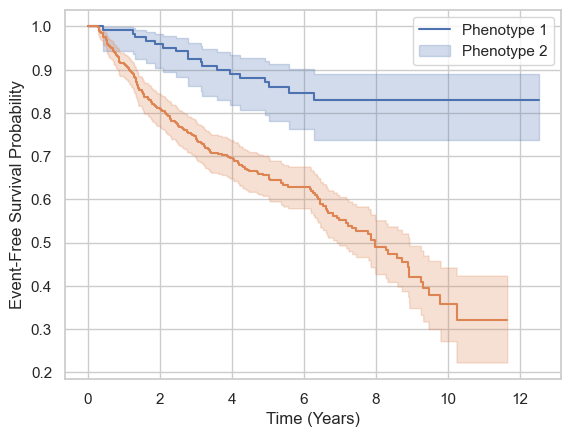

[0.1488908736378146]


[(<models.model.GMM_Survival at 0x7fce8c466a30>,
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [2]:
from copy import deepcopy
from sklearn.model_selection import ParameterGrid

from main import train
from utils.utils import get_purity

param_grid = {
    "latent_dim": range(2,32),
    "layers": [[100]],
}

# param_grid = {'num_clusters': [2],
#               'learning_rate': [1e-3],
#               "weibull_shape": [2.],
#               "seed": [0],
#               "layers": [[32, 64]],
#               "activation": ["selu"],
#               }

params = ParameterGrid(param_grid)

models = []
for param in params:
    cfg = {k: param[k] if k in param else v for k, v in cfg0.items()}
    print(cfg)
    x_tr, x_val, y_tr, y_val = train_test_split(
        x, y, train_size=cfg0["train_size"], random_state=cfg0["seed"])
    model, history = train(x_tr, y_tr, config=cfg, validation_data=(x_val, y_val))
    phe_val = model.get_phenotypes(x_val, y_val)
    print(get_purity(y_val, phe_val))
    models.append((model, phe_val, history))
    
models

In [ ]:
from copy import deepcopy
from sklearn.model_selection import ParameterGrid

from main import train
from utils.utils import get_purity

param_grid = {
    "latent_dim": range(2,32),
    "layers": [[50,100]],
}

# param_grid = {'num_clusters': [2],
#               'learning_rate': [1e-3],
#               "weibull_shape": [2.],
#               "seed": [0],
#               "layers": [[32, 64]],
#               "activation": ["selu"],
#               }

params = ParameterGrid(param_grid)

models = []
for param in params:
    cfg = {k: param[k] if k in param else v for k, v in cfg0.items()}
    print(cfg)
    x_tr, x_val, y_tr, y_val = train_test_split(
        x, y, train_size=cfg0["train_size"], random_state=cfg0["seed"])
    model, history = train(x_tr, y_tr, config=cfg, validation_data=(x_val, y_val))
    phe_val = model.get_phenotypes(x_val, y_val)
    print(get_purity(y_val, phe_val))
    models.append((model, phe_val, history))
    
models

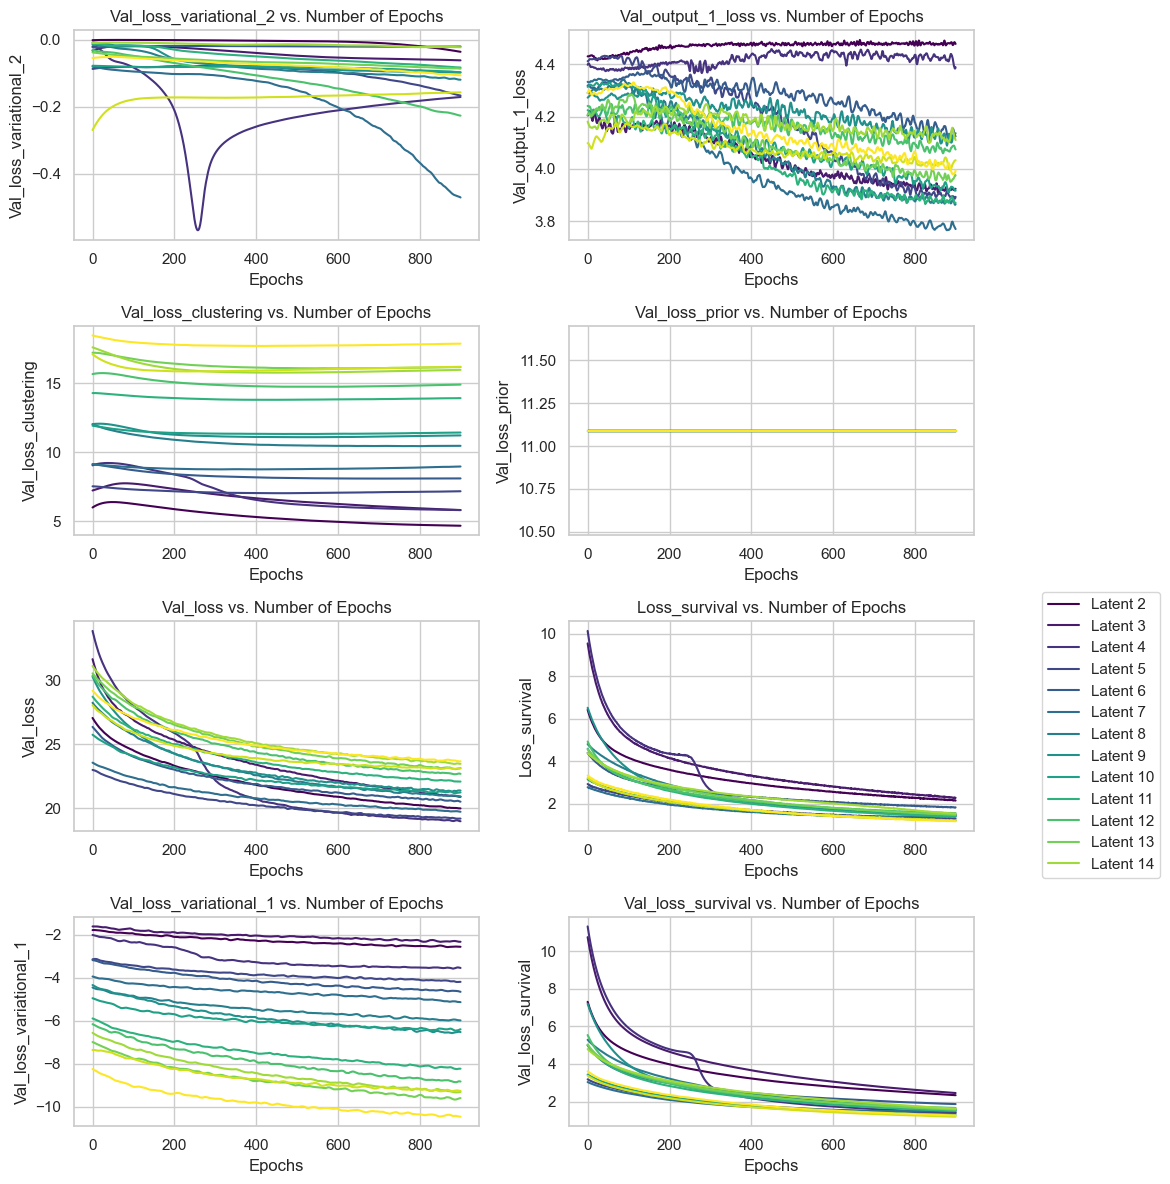

In [3]:
from matplotlib import pyplot as plt
import numpy as np

hists0 = [res[-1] for res in models]
hists = hists0[:15]

# Gather all unique 'loss' metric names across all histories
loss_keys = set()
for hist in hists:
    for key in hist.history.keys():
        if 'loss' in key and "val" in key:
            loss_keys.add(key)

# Determine the number of rows needed for the subplot grid
num_loss_keys = len(loss_keys)
num_columns = 2
num_rows = num_loss_keys // num_columns + (num_loss_keys % num_columns > 0)

# Create a figure to hold the subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 3 * num_rows))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the array for easy iteration

# Use the 'tab20c' colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(hists)))

# Now, plot each type of loss metric in its own subplot
for idx, key in enumerate(loss_keys):
    ax = axes[idx]
    
    for hist_idx, hist in enumerate(hists):
        if key in hist.history:  # Check if the current history has the metric
            ax.plot(hist.history[key][100:], label=f'{key}', color=colors[hist_idx])
    
    ax.set_title(f"{key.capitalize()} vs. Number of Epochs")
    ax.set_xlabel("Epochs")
    ax.set_ylabel(f"{key.capitalize()}")
    ax.grid(True)

# Add a legend outside of the last subplot
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, [f"Latent {i}" for i in range(2, len(hists))], loc='upper left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0.)

# Adjust the layout
plt.tight_layout()
plt.show()

In [55]:
2+np.argmin([hist.history["val_output_1_loss"][-1] for hist in hists])

7

In [47]:
[hist.history["val_output_1_loss"][-1] for hist in hists]

[4.2506866455078125,
 4.204614639282227,
 3.940070629119873,
 4.266416072845459,
 4.35528039932251,
 3.7341201305389404,
 3.9280002117156982,
 4.248241901397705,
 3.87518572807312,
 3.782745599746704,
 3.8447988033294678,
 4.243215560913086,
 4.3118438720703125,
 4.007174491882324,
 4.095113754272461,
 4.240022659301758,
 4.205158710479736,
 4.196302890777588,
 4.066278457641602,
 4.066929817199707,
 4.100606918334961,
 4.157233238220215,
 4.197788715362549,
 4.219834804534912,
 4.004380226135254,
 4.1721577644348145,
 4.300935745239258,
 4.176315784454346,
 4.0710530281066895,
 4.102206230163574]

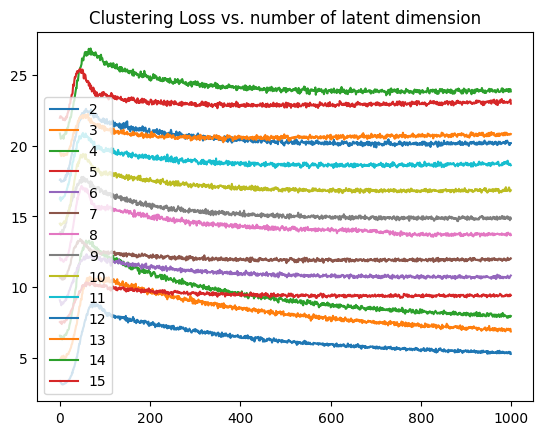

In [ ]:
from matplotlib import pyplot as plt


clustering_losses = np.array([hist.history["loss_clustering"] for hist in hists])

plt.title("Clustering Loss vs. number of latent dimension")
plt.plot(clustering_losses.T)
plt.legend([str(i) for i in range(2, 16)])


## Vadesc